In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

## Fonctions créé pour l'evalutaion des modèles (voir print_test_results.py) :

# Recupère et Affiche le meilleur modèle trouvé par GridSearch
from print_test_results import get_test_results, print_test_results
# Plot les predictions face aux valeurs attendues
from print_test_results import plot_scatter_predictions
# Affiche l'importance (coef_ ou feature_importances_) du meilleur modèle
from print_test_results import plot_top_coefficients_or_importances
# Compare les resultats des meilleurs modèles FR et DE 
from print_test_results import get_comparison_table
from IPython.display import Markdown

# KNeighborsRegressor

Nous utlisons la classe `GridSearchCV` pour trouver la combinaison de *Transformers* et d'hyperparametres donnant les meilleurs resultats. 

GridSearchCV est une méthode de validation croisée pour sélectionner les meilleurs hyperparamètres d'un modèle d'apprentissage automatique en évaluant les performances de celui-ci sur un ensemble de paramètres prédéfinis. Elle effectue une recherche exhaustive de tous les paramètres spécifiés dans une grille prédéfinie afin d'identifier la combinaison optimale de paramètres pour le modèle.

Nous allons utiliser la classe `Pipeline` pour eviter la fuite de données de l'ensemble de test sur l'entrainement des modèles.
De plus `Pipeline` nous permet de faire varier les hyperparametres mais aussi les transformers lors de la recherche exhaustive effectuée par GridSearch.

In [2]:
pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', None),
    ('model', KNeighborsRegressor())
])

Nous definissions maintennat les parametres a faire varier:
- Trois façons de traiter les valeurs manquantes : les retirer ('constant' + fill_value = 'None'), ou les remplacer par le médiane ou la moyenne

```python
'imputer__strategy': ['constant', 'mean', 'median'],
    'imputer__fill_value': [None],
```

- 2 mises a echelles : Standardisation, et une normalisation robuste face aux valeurs aberrantes (RobustScaler : soustraction par la médiane et divison par l'IQR)

```python
'scaler' :  [StandardScaler(), RobustScaler()],
```

- Differentes valeurs de K:
```python
'model__n_neighbors': range(1, 21),
```
- Differents calculs de distances : 
```python
'model__metric': ['euclidean', 'manhattan', 'minkowski']
```

In [3]:
param_grid = {
    'imputer__strategy': ['constant', 'mean', 'median'],
    'imputer__fill_value': [None],
    'scaler' :  [StandardScaler(), RobustScaler()],
    'model__n_neighbors': range(1, 21),
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

Nous evaluerons les modèles trouvés par `GridSearchCV` avec la coefficient de determination R2:

In [4]:
scoring = {
    'r2' : 'r2',
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
}

Les modèles seront evalué avec une 5 validation croisée

In [5]:
refit = 'r2'
cv = 5

On recupere les configurations et les scores des meilleurs modéles de la France et de l'Allemange dans la variable `test_results`:

In [6]:
test_results = {
    'fr':{},
    'de':{}
}

# France

In [7]:
data_fr = pd.read_csv('data/Data_FR.csv', index_col='ID')
data_fr.shape

(680, 34)

In [8]:
X = data_fr.drop('TARGET', axis=1)
y = data_fr['TARGET']
title = 'KNeighborsRegressor FR'

In [9]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=cv, refit=refit, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

test_results['fr'] = get_test_results(grid_search, X_test, y_test, y_pred)
print_test_results(test_results['fr'], refit, title=title)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits

KNeighborsRegressor FR
 Best estimator: 
  imputer : SimpleImputer(strategy='constant')
  scaler : RobustScaler()
  model : KNeighborsRegressor(metric='manhattan', n_neighbors=15)
 Metrics:
  rmse: 1.418
  r2: -0.007
  r2 ajusté: -0.333
  spearman: 0.114
CPU times: total: 2.88 s
Wall time: 15.5 s


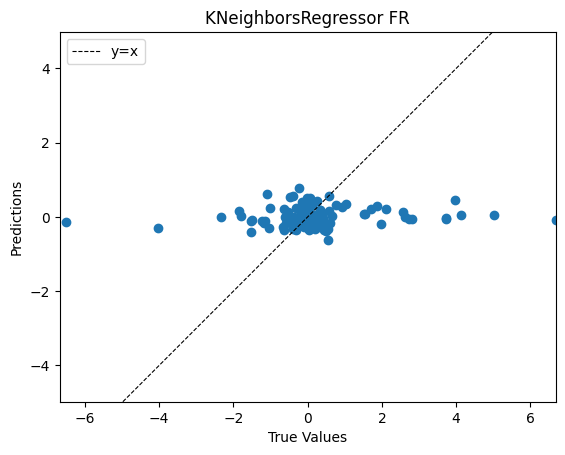

In [10]:
plot_scatter_predictions(y_test, y_pred, title=title)

# Allemagne

In [11]:
data_de = pd.read_csv('data/Data_DE.csv', index_col='ID')
data_de.shape

(596, 34)

In [12]:
X = data_de.drop('TARGET', axis=1)
y = data_de['TARGET']
title = 'KNeighborsRegressor DE'

In [13]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=cv, refit=refit, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

test_results['de'] = get_test_results(grid_search, X_test, y_test, y_pred)
print_test_results(test_results['de'], refit, title=title)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits

KNeighborsRegressor DE
 Best estimator: 
  imputer : SimpleImputer(strategy='constant')
  scaler : RobustScaler()
  model : KNeighborsRegressor(metric='euclidean', n_neighbors=20)
 Metrics:
  rmse: 1.048
  r2: 0.036
  r2 ajusté: -0.334
  spearman: 0.28
CPU times: total: 3.52 s
Wall time: 10.6 s


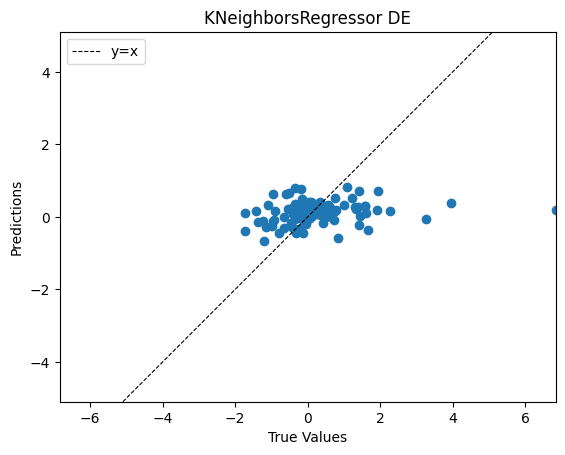

In [14]:
plot_scatter_predictions(y_test, y_pred, title=title)

# Conclusion

In [16]:
markdown_table = get_comparison_table(test_results, title='KNeighborsRegressor')
Markdown(markdown_table)

| KNeighborsRegressor      | FR                                       | DE                                       |
|-------------|--------------------------------------------|--------------------------------------------|
| Imputer     | SimpleImputer(strategy='constant')   | SimpleImputer(strategy='constant')   |
| Scaler      | RobustScaler()    | RobustScaler()    |
| Model       | KNeighborsRegressor(metric='manhattan', n_neighbors=15)                                 | KNeighborsRegressor(metric='euclidean', n_neighbors=20)                                 |
| RMSE        | 1.418               | 1.048               |
| R2          | -0.007                 | 0.036                 |
| R2 ajusté   | -0.333          | -0.334          |
| Spearman    | 0.114           | 0.28           |

In [17]:
# store results 
# pickle fait partie de la bibliotheque standard python (built-in)
import pickle

with open('results/KNeighborsRegressor.pkl', 'wb') as f:
    pickle.dump(test_results, f)